# 爬取虎扑的赛后评论，并分析

In [33]:
import requests
import re
from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.font_manager import _rebuild
_rebuild()

## 找到赛后链接

In [2]:
def order_win_lose(title):
    pattern = '\[赛后\](.*?)(\d+)-(\d+)(.*?)，'
    game_result = re.findall(pattern,title,re.S)[0]
    team_1 = game_result[0]
    team_2 = game_result[3].replace('不敌','')
    if float(game_result[1])>float(game_result[2]):
        return (team_1,team_2)
    else:
        return (team_2,team_1)

In [3]:
order_win_lose('[赛后]公牛86-118不敌火箭，马尔卡宁22+4，戈登31分，保罗13+10，火箭十连胜')

('火箭', '公牛')

In [4]:
# url:'https://bbs.hupu.com/vote'
# sample target: ('https://bbs.hupu.com/21797416.html',
# '[赛后]公牛86-118火箭，马尔卡宁22+4，戈登31分，保罗13+10，火箭十连胜',
# '20')
def get_after_game_post(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'lxml')
    lis = soup.find_all('li')
    targets = []
    for li in lis:
        target = li.find('a',class_='truetit')
        if target!=None and target.text.find('[赛后]')!=-1:
            page_n = li.find('span',class_='multipage').find_all('a')[-1].text 
            targets.append(('https://bbs.hupu.com'+target['href'],order_win_lose(target.text),page_n))
    return targets

## 统计评论人主队

In [5]:
def counter_fans(post_url,page_n):
    counter = Counter()
    i=1
    while i<=page_n:
        try:
            after_game_url =post_url.format(i)
            response = requests.get(after_game_url)
            # <div uname="疯狂的麦克斯4" uid="278913245705307" class="j_u">
            #<a href="https://my.hupu.com/278913245705307" target="_blank" class="headpic"><img src="https://i3.hoopchina.com.cn/user/header/20170415/149222410134740_small_1.jpg" width="45" height="45" alt="疯狂的麦克斯4"></a>
            #</div>
            results = re.findall('<a\sclass="u"\starget="_blank"\shref="https://my.hupu.com/(.*?)".*?>',response.text,re.S)
            fans = []
            for result in results:
                usernum = result
                url = 'https://my.hupu.com/{}'.format(usernum)
                resp = requests.get(url)
                pat = re.compile('<span.*?>NBA主队.*?<a.*?>(.*?)</a>.*?',re.S)
                team = re.findall(pat,resp.text)
                if len(team)>0:
                    fans.append(team[0])
                else:
                    fans.append('无主队')
            counter.update(fans)
            print('in {} page {}'.format(post_url,i))
            i+=1
        except Exception:
            print('end')
    return counter

In [6]:
results = []
for i in range(1,11):
    url = 'https://bbs.hupu.com/vote-{}'.format(i)
    post_infos = get_after_game_post(url)
    for post in post_infos:
        post_url = post[0]
        page_n = int(post[2])
        counter = counter_fans(post_url,page_n)
        results.append((post[1][0],post[1][1],counter))
    print('complete {}/10'.format(i))

in https://bbs.hupu.com/21805964.html page 1
in https://bbs.hupu.com/21805964.html page 2
in https://bbs.hupu.com/21805964.html page 3
in https://bbs.hupu.com/21805964.html page 4
in https://bbs.hupu.com/21805964.html page 5
in https://bbs.hupu.com/21807714.html page 1
in https://bbs.hupu.com/21807714.html page 2
in https://bbs.hupu.com/21807714.html page 3
in https://bbs.hupu.com/21807714.html page 4
in https://bbs.hupu.com/21807714.html page 5
in https://bbs.hupu.com/21807714.html page 6
in https://bbs.hupu.com/21807714.html page 7
in https://bbs.hupu.com/21807714.html page 8
in https://bbs.hupu.com/21807714.html page 9
in https://bbs.hupu.com/21807714.html page 10
in https://bbs.hupu.com/21807714.html page 11
in https://bbs.hupu.com/21807714.html page 12
in https://bbs.hupu.com/21807714.html page 13
in https://bbs.hupu.com/21807714.html page 14
in https://bbs.hupu.com/21807714.html page 15
in https://bbs.hupu.com/21807714.html page 16
in https://bbs.hupu.com/21807714.html page 17
in

In [7]:
result_df = pd.DataFrame(results)
result_df.columns = ['win','loss','count']

In [8]:
result_df

,win,loss,count
0,篮网,魔术,"{'火箭': 5, '无主队': 75, '湖人': 25, '凯尔特人': 15, '活塞..."
1,凯尔特人,爵士,"{'火箭': 100, '雷霆': 100, '无主队': 260, '马刺': 60, '..."
2,湖人,独行侠,"{'火箭': 45, '无主队': 255, '湖人': 225, '骑士': 30, '凯..."
3,湖人,独行侠,"{'火箭': 45, '无主队': 255, '湖人': 225, '骑士': 30, '凯..."
4,骑士,黄蜂,"{'火箭': 24, '马刺': 168, '无主队': 432, '黄蜂': 120, '..."
5,森林狼,老鹰,"{'火箭': 72, '篮网': 48, '尼克斯': 24, '马刺': 48, '湖人'..."
6,76人,尼克斯,"{'火箭': 18, '无主队': 144, '76人': 108, '马刺': 9}"
7,热火,骑士,"{'火箭': 198, '马刺': 110, '无主队': 220, '骑士': 88, '..."
8,凯尔特人,太阳,"{'火箭': 36, '凯尔特人': 228, '76人': 36, '无主队': 144,..."
9,快船,太阳,"{'火箭': 3, '无主队': 60, '骑士': 3, '快船': 3, '凯尔特人': 3}"


In [9]:
count_table = pd.DataFrame()
for i in range(len(result_df)):
    s1 = pd.Series(result_df['count'][i])
    count_table = pd.concat([count_table,s1],axis=1)

In [10]:
count_table = count_table.T
count_table.reset_index(inplace=True)

In [11]:
final_table = pd.concat([result_df[['win','loss']],count_table],axis=1)
final_table = final_table.drop('index',axis=1)
final_table = final_table.fillna(0)

,win,loss,index,76人,公牛,凯尔特人,勇士,太阳,奇才,尼克斯,...,爵士,独行侠,猛龙,篮网,雄鹿,雷霆,马刺,骑士,鹈鹕,黄蜂
0,篮网,魔术,0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1,凯尔特人,爵士,0,NaN,NaN,100.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,60.0,NaN,NaN,NaN
2,湖人,独行侠,0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN
3,湖人,独行侠,0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN
4,骑士,黄蜂,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,168.0,96.0,NaN,120.0


In [17]:
final_table

,win,loss,index,76人,公牛,凯尔特人,勇士,太阳,奇才,尼克斯,...,爵士,独行侠,猛龙,篮网,雄鹿,雷霆,马刺,骑士,鹈鹕,黄蜂
0,篮网,魔术,0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1,凯尔特人,爵士,0,NaN,NaN,100.0,20.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0,60.0,NaN,NaN,NaN
2,湖人,独行侠,0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN
3,湖人,独行侠,0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN
4,骑士,黄蜂,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,168.0,96.0,NaN,120.0
5,森林狼,老鹰,0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,...,NaN,NaN,NaN,48.0,NaN,12.0,48.0,12.0,NaN,NaN
6,76人,尼克斯,0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN
7,热火,骑士,0,NaN,NaN,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,44.0,NaN,110.0,88.0,NaN,NaN
8,凯尔特人,太阳,0,36.0,NaN,228.0,36.0,NaN,NaN,NaN,...,12.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
9,快船,太阳,0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN


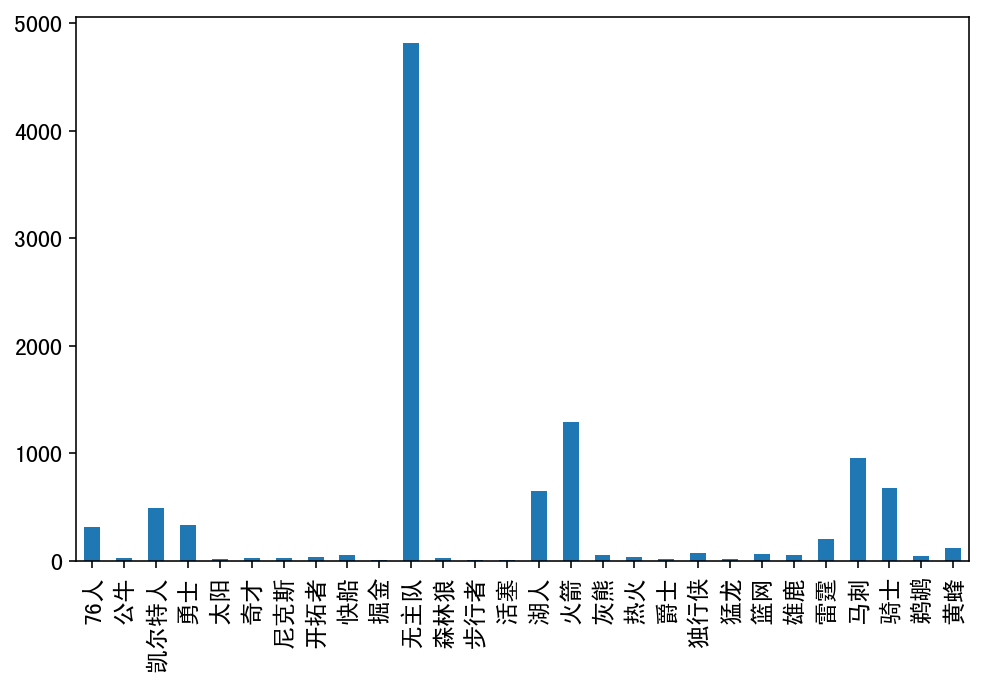

In [39]:
np.sum(final_table.iloc[:,3:],axis=0).plot(kind='bar',figsize=(8,5),fontsize=12)